In [138]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import genextreme
import numpy as np
import pandas as pd
from scipy.stats import genextreme
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Genextreme method computation for different return period and different grid point

### Exploration from tasmax from EC-Earth3-Veg historical dataset

Computation of the extreme distribution over historical datasets. Chosen block are 1-year sized.

In [137]:
ds_tasmax = xr.open_dataset("tasmaxAdjust_FR-Metro_EC-Earth3-Veg_historical_r1i1p1f1_KNMI_RACMO23E_v1-r1_MF-CDFt-ANASTASIA-SAFRAN-1985-2014_day_19500101-20141231.nc")
ds_tasmax

<xarray.Dataset> Size: 2GB
Dimensions:         (y: 134, x: 143, nbounds: 4, time: 23376, bnds: 2)
Coordinates:
    lon             (y, x) float64 153kB ...
    lat             (y, x) float64 153kB ...
  * x               (x) float64 1kB 6e+04 6.8e+04 ... 1.188e+06 1.196e+06
  * y               (y) float64 1kB 1.617e+06 1.625e+06 ... 2.673e+06 2.681e+06
  * time            (time) datetime64[ns] 187kB 1951-01-01T12:00:00 ... 2014-...
Dimensions without coordinates: nbounds, bnds
Data variables:
    lon_bnds        (y, x, nbounds) float64 613kB ...
    lat_bnds        (y, x, nbounds) float64 613kB ...
    LambertParisII  int32 4B ...
    tasmaxAdjust    (time, y, x) float32 2GB ...
    time_bnds       (time, bnds) datetime64[ns] 374kB ...
Attributes: (12/71)
    title:                           RACMO23E model output corrected over met...
    summary:                         Data were post-processed by the Météo-Fr...
    id:                              hdl:21.14103/14d08250-8908-443e-b70c-8f8...
    Conventions:                     CF-1.11 ACDD-1.3
    standard_name_vocabulary:        CF Standard Name Table v81
    input_domain:                    Europe
    ...                              ...
    date_created:                    2025-11-13T17:55:44.501920
    product:                         bias-adjusted output
    license:                         CORDEX model data produced by KNMI is li...
    product_version:                 v1
    comment:                         Preliminary data released in the Fall 20...
    keywords:                        temperature, climate, France, maximal ne...

/home/viretl/miniconda3/envs/earthkit/lib/python3.13/site-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


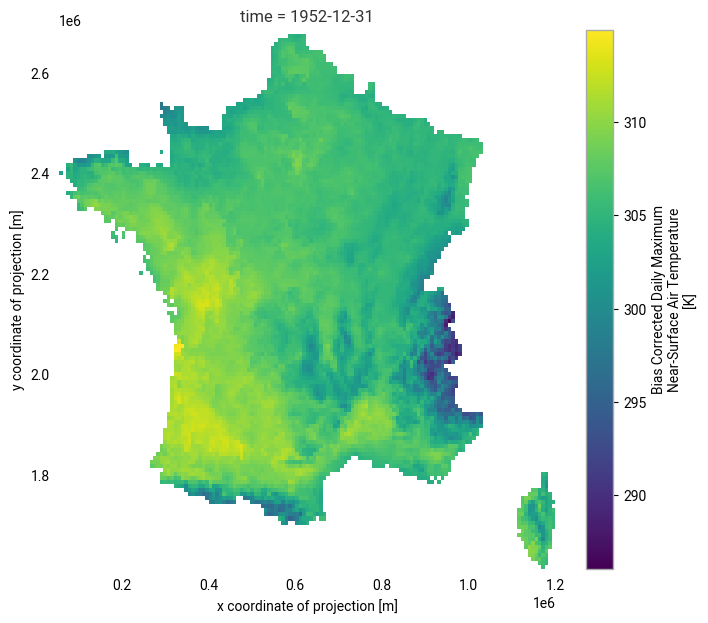

In [141]:
# Make sure time is in datetime format
ds_tasmax["time"] = pd.to_datetime(ds_tasmax.time.values)

# Resample by year and take maximum of the year
annual_max = ds_tasmax.resample(time="1Y").max(dim="time")
# annual_max_without_nan = annual_max.dropna(dim="y")
annual_max.isel(time=1)["tasmaxAdjust"].plot()


(array([1.00000e+02, 7.98000e+02, 2.80000e+03, 7.95900e+03, 2.80590e+04,
        1.22141e+05, 2.18108e+05, 1.38588e+05, 5.39280e+04, 2.30300e+03]),
 array([286.07196045, 289.22088623, 292.36981201, 295.51876831,
        298.66769409, 301.81661987, 304.96554565, 308.11447144,
        311.26342773, 314.41235352, 317.5612793 ]),
 <BarContainer object of 10 artists>)

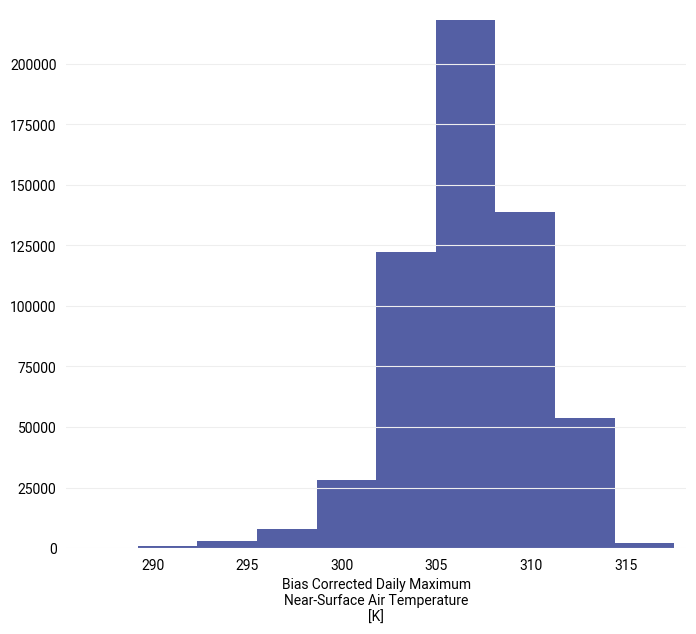

In [142]:
# Plot the historical distribution of annual maximum of tasmax
xr.plot.hist(annual_max.tasmaxAdjust)

### Fitting the GenEV distribution to the annual maximum dataset

Test: fitting the genextreme distribution to the annual maximum dataset of tasmax, covering years from 1951 to 2014 for on egrid point and for the Earth3Veg

No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
The return temperature is 36 for the 3 years period


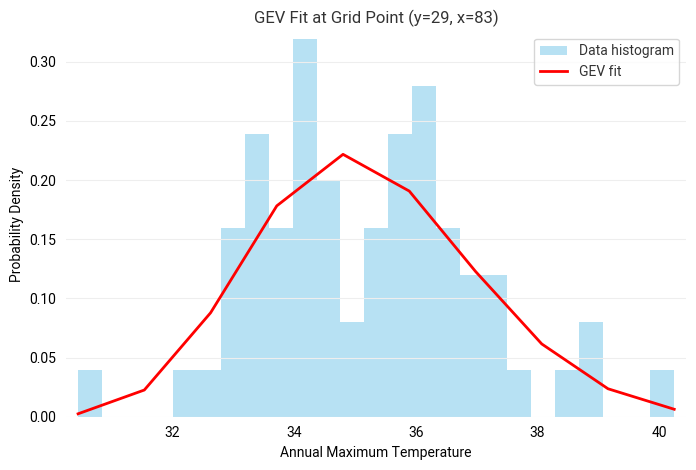

In [146]:
varname = "tasmaxAdjust"

# Example grid point indices
i, j = 29,83 # or use coordinates (close to Montpellier)
period = 3 # test of a return period 
# Select the dataarray for that variable
da = annual_max[varname]

# Extract the series at that grid point
y_data = np.round(da.isel(y=i, x=j).values,1) - 273.15  # now this is a 1D array over time

# Check for NaNs
if np.any(np.isnan(y_data)):
    print("There is at least one NaN in the data")
else:
    print("No NaNs, all values are finite")

# Check for missing data
if np.all(np.isfinite(y_data)):
    c, loc, scale = genextreme.fit(y_data)
    print(f"Shape (c): {c}, Location (loc): {loc}, Scale: {scale}")

        # Create a range for plotting the PDF
    x = np.linspace(np.min(y_data), np.max(y_data), int(np.round(np.max(y_data)-np.min(y_data))))

    # GEV PDF
    pdf = genextreme.pdf(x, c, loc=loc, scale=scale)

    return_value = genextreme.ppf(1-1/period, c, loc=loc, scale=scale)
    print(f"The return temperature is {round(return_value)} for the {period} years period")

    # Plot histogram and fitted PDF
    plt.figure(figsize=(8,5))
    plt.hist(y_data, bins=25, density=True, alpha=0.6, color='skyblue', label='Data histogram')
    plt.plot(x, pdf, 'r-', lw=2, label='GEV fit')
    plt.xlabel('Annual Maximum Temperature')
    plt.ylabel('Probability Density')
    plt.title(f'GEV Fit at Grid Point (y={i}, x={j})')
    plt.legend()
    plt.show()
else:
    c, loc, scale = np.nan, np.nan, np.nan
    print("Data contains missing values, parameters set to NaN")
    


In [147]:
# Draft : Mise en fonction (pas optimisée du tout)

def fit_gev(varname,i,j,ds,period):

    # Select the dataarray for that variable
    da = ds[varname]

# Extract the series at that grid point
    y_data = np.round(da.isel(y=i, x=j).values,1) - 273.15  # now this is a 1D array over time

    # Check for NaNs
    if np.any(np.isnan(y_data)):
        print("There is at least one NaN in the data")
    else:
        print("No NaNs, all values are finite")

    # Check for missing data
    if np.all(np.isfinite(y_data)):
        c, loc, scale = genextreme.fit(y_data)
        # print(f"Shape (c): {c}, Location (loc): {loc}, Scale: {scale}")

            # Create a range for plotting the PDF
        x = np.linspace(np.min(y_data), np.max(y_data), int(np.round(np.max(y_data)-np.min(y_data))))

        # GEV PDF
        pdf = genextreme.pdf(x, c, loc=loc, scale=scale)

        return_period= genextreme.ppf(1-1/period, c, loc=loc, scale=scale)
        # print(return_period)

        # # Plot histogram and fitted PDF
        # plt.figure(figsize=(8,5))
        # plt.hist(y_data, bins=25, density=True, alpha=0.6, color='skyblue', label='Data histogram')
        # plt.plot(x, pdf, 'r-', lw=2, label='GEV fit')
        # plt.xlabel('Annual Maximum Temperature')
        # plt.ylabel('Probability Density')
        # plt.title(f'GEV Fit at Grid Point (y={i}, x={j})')
        # plt.legend()
        # plt.show()
    else:
        c, loc, scale = np.nan, np.nan, np.nan
        # print("Data contains missing values, parameters set to NaN")
        return_period=np.nan

    return return_period


varname = "tasmaxAdjust"
i, j = 29,83 # or use coordinates
fit_gev(varname,i,j,annual_max,100)  

No NaNs, all values are finite


np.float64(39.600110755707085)

No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
-inf
No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
39.10666770791241
No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
39.6069009262595
No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
39.870121257508735
No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
40.044688275436236
No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
40.17349062902702
No NaNs, all values are finite
Shape (c): 0.19857681324631998, Location (loc): 34.490010020280096, Scale: 1.6944220071020002
40.27462435181903
No NaNs, al

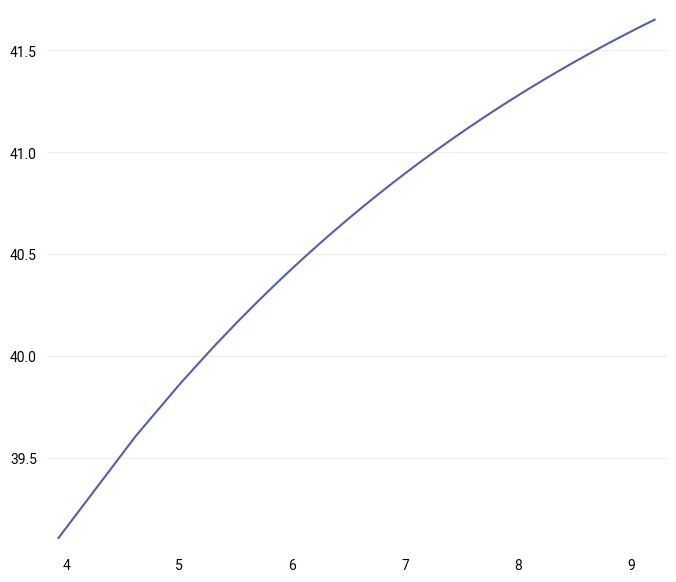

In [103]:
# Créer la liste des r
r_values = range(1, 10000, 50)

# Calculer y pour chaque r
y = [fit_gev(varname, i, j, annual_max, r) for r in r_values]

# Calculer x = log(r)
x = [np.log(r) for r in r_values]

plt.plot(x,y)

#### Vectorized function: 
Helps the application of the fitting to each grid point.

In [148]:

def gev_return_level(y_series, period):
    """
    y_series: 1D array (time) pour un point
    period: return period
    """
    # Si NaN présent, retourner NaN
    if np.any(np.isnan(y_series)):
        return np.nan
    # Fit GEV
    c, loc, scale = genextreme.fit(y_series)
    # Retourner le niveau de retour
    return genextreme.ppf(1 - 1/period, c, loc=loc, scale=scale)

# Appliquer sur xarray
return_levels = xr.apply_ufunc(
    gev_return_level,
    da,
    kwargs={'period': 10},
    input_core_dims=[['time']],   # la fonction s'applique le long de 'time'
    vectorize=True,               # vectorisation automatique
    dask='parallelized',          # optionnel si le dataset est dask
    output_dtypes=[float]
)

return_levels

<xarray.DataArray 'tasmaxAdjust' (y: 134, x: 143)> Size: 153kB
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 309.03565507,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 308.83857852,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]], shape=(134, 143))
Coordinates:
    lon      (y, x) float64 153kB -4.097 -4.002 -3.907 ... 10.57 10.68 10.79
    lat      (y, x) float64 153kB 41.36 41.37 41.37 41.38 ... 50.85 50.84 50.83
  * x        (x) float64 1kB 6e+04 6.8e+04 7.6e+04 ... 1.188e+06 1.196e+06
  * y        (y) float64 1kB 1.617e+06 1.625e+06 ... 2.673e+06 2.681e+06

#### Test for exploiting grid points localized closed to a SEVESO site (for example; close to Lyon)

   id                                           geometry
0   1  POLYGON ((4.57713 46.06657, 5.23015 46.03328, ...
1   2  POLYGON ((0.3312 49.68253, 0.87922 49.67997, 1...
2   3  POLYGON ((5.69623 45.14017, 5.72312 45.13953, ...
3   4  POLYGON ((5.98081 44.07213, 5.98961 44.09278, ...
POLYGON ((4.577127700119549 46.06657090825667, 5.230151037099208 46.03327952244987, 5.381242711145482 45.8437747109342, 5.396607966133239 45.32135604135048, 5.14820301049784 44.93210291499397, 4.630906092576697 45.129290354003516, 4.505423176843351 45.65683077524983, 4.577127700119549 46.06657090825667))
0.8014865239950126


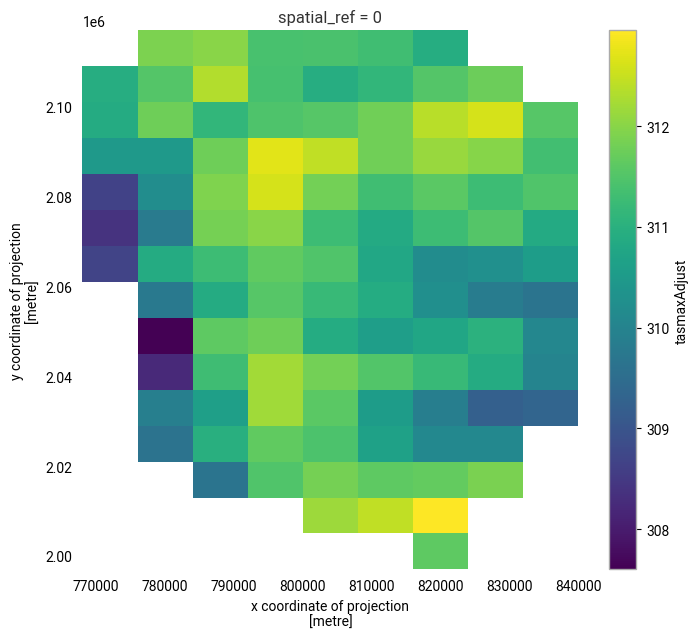

In [149]:
import geopandas as gpd
import rioxarray

# Load the shapefile
shapefile_path = "zone_test/zone_test.shp"
gdf = gpd.read_file(shapefile_path)

# Inspect the data
print(gdf.head())

# Access geometries (as Shapely objects)
geometries = gdf.geometry

# Example: get the first geometry
first_geom = geometries.iloc[0]
print(first_geom)  # This is a Shapely object
print(first_geom.area)  # You can use Shapely methods

return_levels = return_levels.rio.write_crs("EPSG:27572", inplace=True)

gdf = gpd.GeoDataFrame({'geometry': [first_geom]}, crs="EPSG:4326")
gdf = gdf.to_crs(return_levels.rio.crs)  # Reproject to Lambert-2


da_clip = return_levels.rio.clip(gdf.geometry, drop=True)
da_clip.plot()

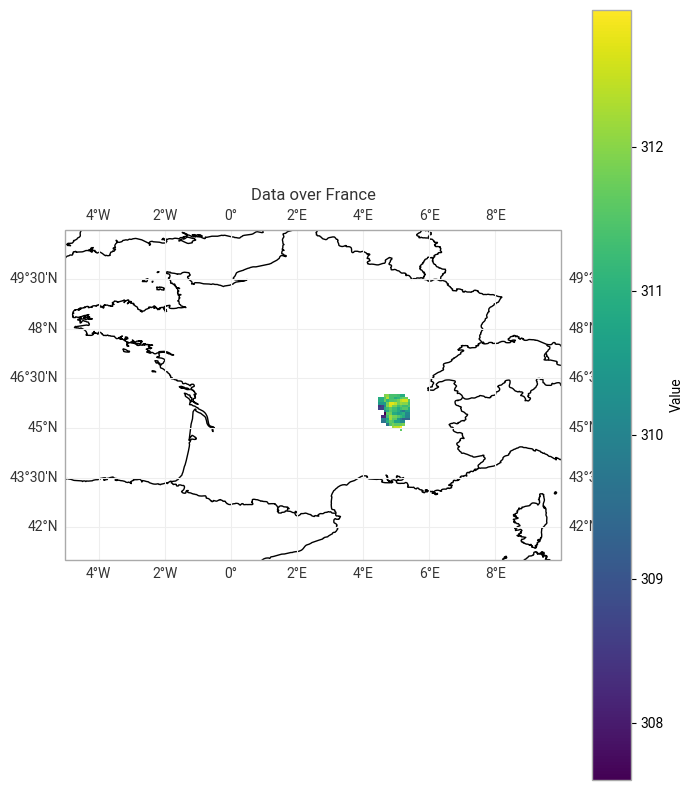

In [150]:
### Are we really in Lyon ? (just to check that Lambert coordinate are quiet accurate)

fig, ax = plt.subplots(figsize=(8, 10),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add country borders
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-5, 10, 41, 51]) 
# Simple plot
da_clip=da_clip.rio.reproject("EPSG:4326")
da_clip.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Value'})

# Optionally add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.title("Data over France")
plt.show()

## Road to operationnal :

Netcdf file produced from (../tasmaxAdjust_FR-Metro_EC-Earth3-Veg_historical_r1i1p1f1_KNMI_RACMO23E_v1-r1_MF-CDFt-ANASTASIA-SAFRAN-1985-2014_day_19500101-20141231.nc)

The output consists in:
  - a dataset conserving initial coordinates (x,y, lat,lon)
  - the return value computed for each return period (2,5,10,20,50)
  - the gev_params to plot the fitted distribution (if needed)

In [153]:
ds = xr.open_dataset("tasmax_RP_GEV.nc")
ds = ds.drop_dims("gev_params")


In order to produce the final production (in dataWrapper), we process the netcdf file to a dataframe to save it as a csv.

In [154]:
da_stacked = ds.stack(points=("y", "x","periods"))
da_stacked.to_dataframe()

lon        lat  return_levels          y  \
y         x         periods                                                   
1617000.0 60000.0   2        -4.096909  41.361364            NaN  1617000.0   
                    5        -4.096909  41.361364            NaN  1617000.0   
                    10       -4.096909  41.361364            NaN  1617000.0   
                    20       -4.096909  41.361364            NaN  1617000.0   
                    50       -4.096909  41.361364            NaN  1617000.0   
...                                ...        ...            ...        ...   
2681000.0 1196000.0 5        10.792424  50.833806            NaN  2681000.0   
                    10       10.792424  50.833806            NaN  2681000.0   
                    20       10.792424  50.833806            NaN  2681000.0   
                    50       10.792424  50.833806            NaN  2681000.0   
                    100      10.792424  50.833806            NaN  2681000.0   

                                     x  periods  
y         x         periods                      
1617000.0 60000.0   2          60000.0        2  
                    5          60000.0        5  
                    10         60000.0       10  
                    20         60000.0       20  
                    50         60000.0       50  
...                                ...      ...  
2681000.0 1196000.0 5        1196000.0        5  
                    10       1196000.0       10  
                    20       1196000.0       20  
                    50       1196000.0       50  
                    100      1196000.0      100  

[114972 rows x 6 columns]

In [120]:
# now points dimension contains all grid cells
df = da_stacked.to_dataframe().drop(columns=["x","y","periods"]).reset_index().dropna()
df

,y,x,periods,lon,lat,return_levels
834,1617000.0,1172000.0,2,9.149498,41.337289,39.039165
835,1617000.0,1172000.0,5,9.149498,41.337289,41.085338
836,1617000.0,1172000.0,10,9.149498,41.337289,42.315520
837,1617000.0,1172000.0,20,9.149498,41.337289,43.410221
838,1617000.0,1172000.0,50,9.149498,41.337289,44.712864
...,...,...,...,...,...,...
113677,2673000.0,620000.0,5,2.620915,51.049429,37.341539
113678,2673000.0,620000.0,10,2.620915,51.049429,38.475242
113679,2673000.0,620000.0,20,2.620915,51.049429,39.363182
113680,2673000.0,620000.0,50,2.620915,51.049429,40.279633


In [135]:
df_wide = df.pivot(index=["x", "y","lat","lon"], columns="periods", values="return_levels")
df_wide=df_wide.reset_index()

In [136]:
df_wide.to_csv("tas_max_RP_GEV_points_all_period_ALL_COLUMNS.csv", index=False)